# Trabajo Práctico 2: Análisis con Random Forest - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba


## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [3]:
from preprocessing import dividir_dataset
from preprocessing import preparar_dataset
from preprocessing import aplicar_one_hot_encoding

In [4]:
from funcionesAuxiliares import graficar_auc_roc
from funcionesAuxiliares import traer_df

## Carga del set de datos
Cargamos el dataset y aplicamos las funciones necesarias para adecuarlo al modelo:

In [5]:
df = traer_df()
df = preparar_dataset(df)
df = aplicar_one_hot_encoding(df)

También segmentamos el dataset en X e y (target), y luego lo dividimos en subsets de entrenamiento y validation development (test)

In [6]:
X, y = dividir_dataset(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

## Búsqueda de hiperparámetros
Definimos los mejores hiperparámetros, que son 'criterio', 'estimadores', 'profundidad' y 'min_samples_leaf' mediante la siguiente función de búsqueda, que utiliza Stratified K-folds cross validation para comparar cada combinación y así obtener la mejor. Nos quedamos con la combinación cuya media de los k-folds(5) tenga la mejor métrica. La métrica de comparación utilizada es AUC-ROC.

In [7]:
def definir_mejores_hiperparametros(X, y):    
    metrics = []
    for criterio in ['gini', 'entropy']:
        for estimadores in [100,200,300,400,500]:
            for profundidad in [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]:                
                kf = KFold(n_splits=5)
                metricas_de_la_combinacion = []
                for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
                    random_forest = RandomForestClassifier(n_jobs = -1,max_depth = profundidad, n_estimators = estimadores, criterion = criterio)
                    random_forest.fit(X.iloc[train_index], y.iloc[train_index])
                    y_pred = random_forest.predict_proba(X.iloc[test_index])[:,1]
                    metricas_de_la_combinacion.append(roc_auc_score(y.iloc[test_index], y_pred))

                metrics.append((profundidad, estimadores, criterio,np.mean(metricas_de_la_combinacion)))
    df_metrics = pd.DataFrame(metrics, columns = ['profundidad_maxima', 'estimadores', 'criterio','rocauc'])
    mejor_combinacion = df_metrics[df_metrics["rocauc"] ==  max(df_metrics.rocauc)]   
    return mejor_combinacion

## Entrenamiento y predicción con el dataset original
Buscamos la mejor combinación de hiperparámetros para este dataset, con la función anteriormente mencionada.

In [8]:
mejor_combinacion = definir_mejores_hiperparametros(X, y)

En caso de que dos o más combinaciones den igual, decidimos quedarnos con la combinación que menor profundidad tenga.


In [9]:
mejor_combinacion = mejor_combinacion[mejor_combinacion['profundidad_maxima'] == mejor_combinacion.profundidad_maxima.min()]

Observamos que la mejor combinación de hiperparámetros es la siguiente:

In [10]:
parametros_random_forest = mejor_combinacion.loc[:].values[0]
mejor_profundidad = parametros_random_forest[0]
mejor_estimadores = parametros_random_forest[1]
mejor_criterio = parametros_random_forest[2]
print(f'Mejor profundidad máxima: {mejor_profundidad}')
print(f'Mejor n° de estimadores: {mejor_estimadores}')
print(f'Mejor criterio: {mejor_criterio}')


Mejor profundidad máxima: 16
Mejor n° de estimadores: 300
Mejor criterio: entropy


Entrenamos un RandomForest con esa combinación de hiperparámetros.

In [11]:
random_forest = RandomForestClassifier(n_jobs = -1,max_depth = mejor_profundidad, n_estimators = mejor_estimadores, criterion = mejor_criterio)
random_forest.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=16, n_estimators=300,
                       n_jobs=-1)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

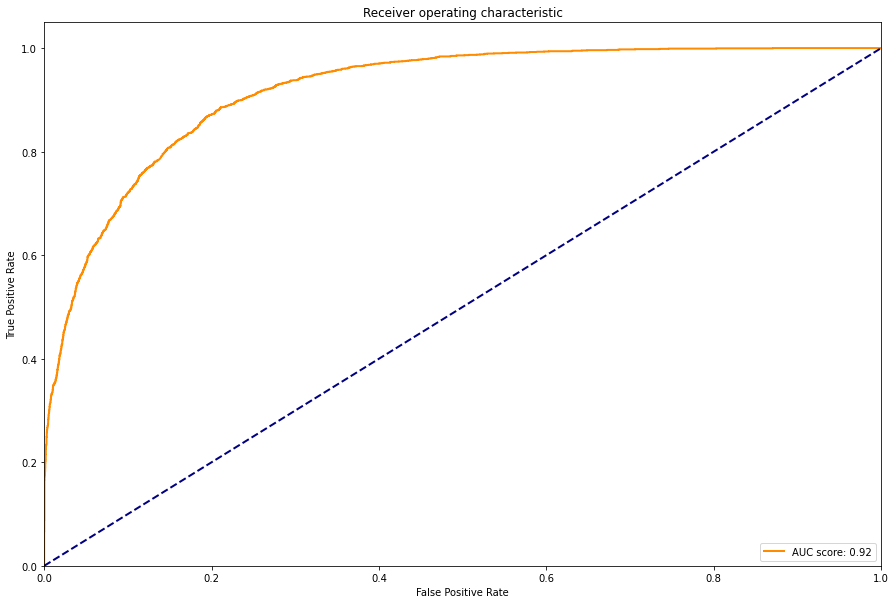

El valor de la metrica AUC-ROC para este modelo es: 0.9177584868787426


In [12]:
y_pred = random_forest.predict(X_test)
y_pred_proba = random_forest.predict_proba(X_test)[:, 1]
graficar_auc_roc(y_test, y_pred_proba)

Podemos observar que 

Mostramos el classification report:

In [13]:
print(classification_report(y_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))


                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.877     0.949     0.912      6159
   Tiene Alto Valor Adquisitivo      0.788     0.587     0.673      1982

                       accuracy                          0.861      8141
                      macro avg      0.833     0.768     0.792      8141
                   weighted avg      0.856     0.861     0.854      8141



Por último, mostramos la matriz de confusión correspondiente:

In [14]:
from funcionesAuxiliares import graficar_matriz_confusion

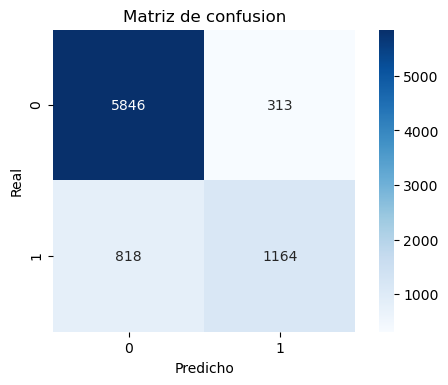

In [15]:
graficar_matriz_confusion(y_test, y_pred)

Podemos ver que

## Entrenamiento y predicción con el dataset ampliado
Como otra técnica de preprocesamiento, decidimos expandir el dataset utilizando clustering para obtener cuatro nuevas columnas. Las columnas corresponden a la utilización de K-means con 2, 4, 6 y 10 como cantidad de clusters usados. 

In [16]:
from preprocessing import expandir_dataset

Expandimos el dataset y realizamos el split del mismo en los subsets de entrenamiento y validación.

In [17]:
X_exp = expandir_dataset(X)
X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(X_exp, y, test_size=0.25, random_state=0)

Buscamos la mejor combinación de hiperparámetros para este dataset.

In [18]:
mejor_combinacion = definir_mejores_hiperparametros(X_exp, y)
mejor_combinacion = mejor_combinacion[mejor_combinacion['profundidad_maxima'] == mejor_combinacion.profundidad_maxima.min()]

A continuación, vemos la mejor combinación de hiperparámetros obtenida.

In [19]:
parametros_random_forest = mejor_combinacion.loc[:].values[0]
mejor_profundidad = parametros_random_forest[0]
mejor_estimadores = parametros_random_forest[1]
mejor_criterio = parametros_random_forest[2]
print(f'Mejor profundidad máxima: {mejor_profundidad}')
print(f'Mejor n° de estimadores: {mejor_estimadores}')
print(f'Mejor criterio: {mejor_criterio}')


Mejor profundidad máxima: 17
Mejor n° de estimadores: 500
Mejor criterio: entropy


Entrenamos un RandomForest con esa combinación de hiperparámetros.

In [20]:
random_forest_expandido = RandomForestClassifier(n_jobs = -1,max_depth = mejor_profundidad, n_estimators = mejor_estimadores, criterion = mejor_criterio)
random_forest_expandido.fit(X_exp_train, y_exp_train)

RandomForestClassifier(criterion='entropy', max_depth=17, n_estimators=500,
                       n_jobs=-1)

Luego, hacemos que este prediga sobre el subset de validation. A continuación se muestra el gráfico de la curva ROC y su respectivo score en la métrica AUC-ROC.

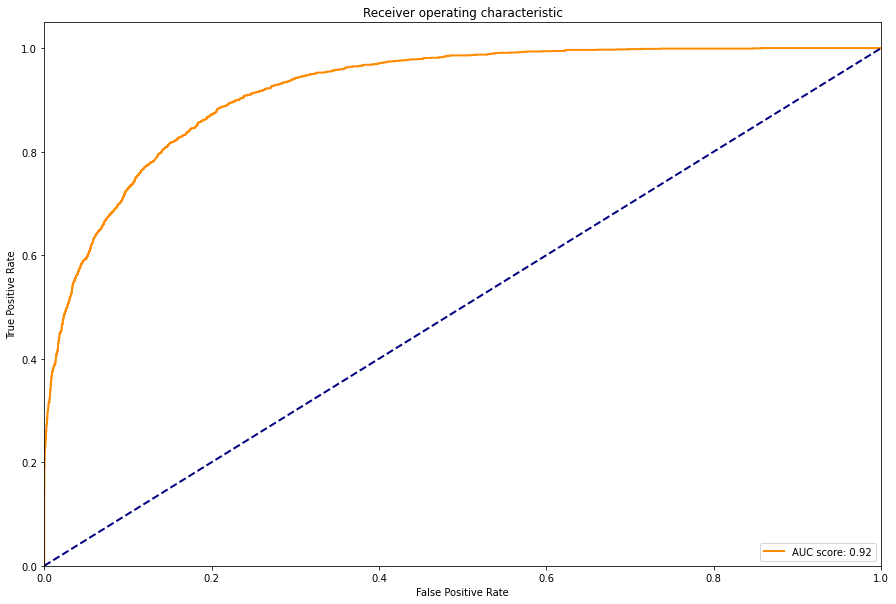

El valor de la metrica AUC-ROC para este modelo es: 0.9207093833132713


In [21]:
y_pred = random_forest_expandido.predict(X_exp_test)
y_pred_proba = random_forest_expandido.predict_proba(X_exp_test)[:, 1]
graficar_auc_roc(y_exp_test, y_pred_proba)

Podemos observar que el score de AUC-ROC 

Mostramos el classification report:

In [22]:
print(classification_report(y_exp_test, y_pred, target_names=['No Tiene Alto Valor Adquisitivo', 'Tiene Alto Valor Adquisitivo'],digits=3))

                                 precision    recall  f1-score   support

No Tiene Alto Valor Adquisitivo      0.879     0.950     0.913      6159
   Tiene Alto Valor Adquisitivo      0.793     0.594     0.679      1982

                       accuracy                          0.863      8141
                      macro avg      0.836     0.772     0.796      8141
                   weighted avg      0.858     0.863     0.856      8141



Por último, mostramos la matriz de confusión correspondiente:

In [23]:
from funcionesAuxiliares import graficar_matriz_confusion

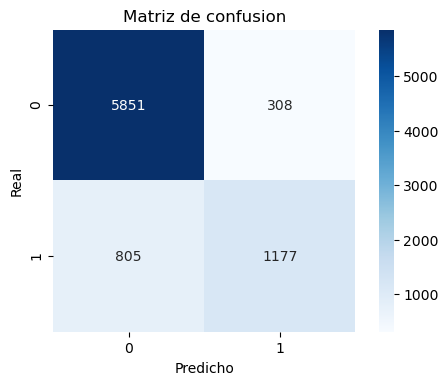

In [24]:
graficar_matriz_confusion(y_exp_test, y_pred)

Podemos ver que el random forest clasifica 

## Predicción con el dataset de test holdout
A continuación, realizamos la predicción con el random forest sin expandir el dataset sobre el dataset de holdout, y la escribimos al archivo 'RandomForest.csv'

In [25]:
from funcionesAuxiliares import traer_holdout
from preprocessing import preparar_holdout
from funcionesAuxiliares import escribir_predicciones

In [26]:
holdout = traer_holdout()
ids, holdout = preparar_holdout(holdout)
holdout = aplicar_one_hot_encoding(holdout)

In [27]:
predicciones = random_forest.predict(holdout)
escribir_predicciones(ids, predicciones, "RandomForest")